In [1]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
#torchinfo package help to visual representation of model
try:
  from torchinfo import summary
except:
  print("[info] couldn't find torchinfo .... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary
  

In [3]:
# try to import going_modular directory, if not available, download it from github
try:
  from going_modular import data_setup, engine
except:
  print("[info] couldn't find going_modular scripts... downloading them from github.")
  !git clone https://github.com/zim10/Deep-learning-using-pytorch.git
  !mv Deep-learning-using-pytorch/going_modular going_modular
  !rm -rf Deep-learning-using-pytorch #remove folder
  from going_modular import data_setup, engine

In [4]:
#!git --version
#!rm -rf Dive-into-deep-learning

In [5]:
#get data
import os
import zipfile
from pathlib import Path
import requests
data_path = Path("data/")
image_path = data_path /"pizza_steak_sushi"
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one....")
  image_path.mkdir(parents=True, exist_ok = True)

  #Downloading pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("downloading pizza, steak, sushi data....")
    f.write(request.content)
  #unzip
  with zipfile.ZipFile(data_path /"pizza_steak_sushi.zip", "r" ) as zip_ref:
    print("unzipping")
    zip_ref.extractall(image_path)



data/pizza_steak_sushi directory exists.


In [6]:
!python going_modular/get_data.py

data/pizza_steak_sushi directory exists.
Unzipping pizza, steak, sushi data...


In [7]:
train_dir = image_path /"train"
test_dir = image_path /"test"

In [8]:
#create a manual transforms using compose
from torchvision import transforms
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std= [0.229, 0.224, 0.225])
])

In [9]:
#create a train and test data loader using manual_transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transforms,
                                                                               batch_size = 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f273554fc70>,
 ['pizza', 'steak', 'sushi'])

In [10]:
#get a pretrainded models weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [11]:
#use auto_transforms
#get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
#create a tran and test dataloader using autotransforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = auto_transforms,
                                                                               batch_size = 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f26b9f16340>,
 ['pizza', 'steak', 'sushi'])

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
#now use a pretrained model in pizza-steak-sushi dataset
#setup the model with pretrained weights and send it to the target device
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights = weights).to(device) #new method
#model = torchvision.models.efficientnet_b0(pretrained = True).to(device) #new method

In [15]:
# getting the summary of model using torchinfo.summary()
summary(model = model,
        input_size=(32, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [16]:
#freeze all base layers in the features section of the model (the feature extractor) by setting requires_grad=False
#feature extractor layers frozen
for param in model.features.parameters():
  param.requires_grad = False

In [17]:
#adjust output classifier portion of the pretrained model, as it has 1000 classes, but our has 3 classes
#ourr new classifier layer should be
torch.manual_seed(42)
torch.cuda.manual_seed(42)
output_shape = len(class_names)
#recreate classifier layer and send to the device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

In [18]:
#output layer has updated, lets get another summary of the model
summary(model = model,
        input_size=(32, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [19]:
#now we got the train model with semi-frozen classifier
#trainmodel
#define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [20]:
#we will train() function which is in the engine.py
# only train the parameters of classifier layer and all of the other parameters in our model have frozen
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from timeit import default_timer as timer
start_time = timer()
#setup training and save result
results = engine.train(model= model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 5,
                       device = device)
end_time = timer()
print(f"[info] total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8703 | train_acc: 0.7773 | test_loss: 0.7900 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.8008 | test_loss: 0.7433 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7114 | train_acc: 0.7578 | test_loss: 0.6344 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6252 | train_acc: 0.7930 | test_loss: 0.6238 | test_acc: 0.8864
[info] total training time: 12.721 seconds


In [22]:
#how to take one .py file (specific file from github repo)
try:
  from helper_functions import plot_loss_curves
except:
  print("[info] couldn't fidn the file, dowloading...")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/zim10/Deep-learning-using-pytorch/main/Deep_learning_exercise/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

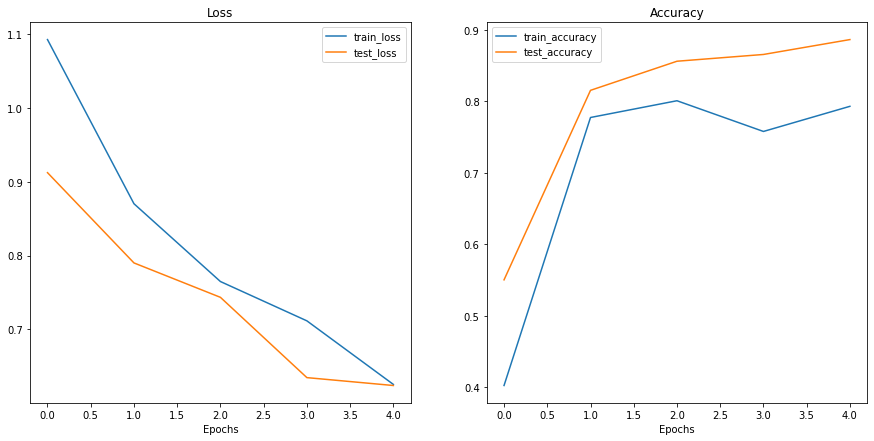

In [23]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [41]:
# make prediction on images from the test dataset
from typing import List, Tuple
from PIL import Image
#1. take a trained model, class names, image path, image size, transform and device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform = None,
                        device: torch.device=device):
  #. 2. open image
  img = Image.open(image_path)
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std = [0.229, 0.224, 0.225]),
    ])
  #4. target decvice
  model.to(device)
  #5. model evaluation mode and inference mode
  model.eval()
  with torch.inference_mode():
    #6. andd an extra dimention
    tranformed_image = image_transform(img).unsqueeze(dim=0)
    #7. make prediction
    target_image_pred = model(tranformed_image.to(device))
    #8. convert logits 
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    #9. convert pred probabilites into labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    #10. plot image with lable and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"pred: {class_names[target_image_pred_label]} | probability: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

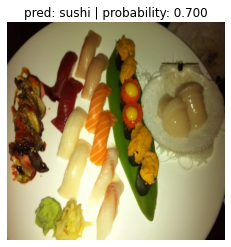

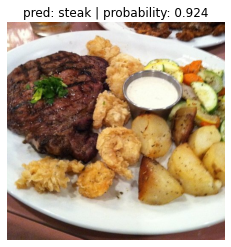

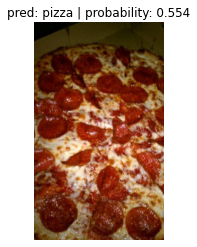

In [42]:
#get a random list of image path from test directory
#need  glob
import random
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) 
test_image_path_sample = random.sample(population = test_image_path_list, k =3)
#call the above functio
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path = image_path,
                      class_names = class_names,
                      image_size = (224, 224))

In [43]:
#custom image load from github
import requests
custom_image_path = data_path / "pizza-3007395__480.jpg"
#download img if it's not in the directory
if not custom_image_path.is_file():
  print("[info] couldn't fidn the file, dowloading...")
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/zim10/Deep-learning-using-pytorch/main/Deep_learning_exercise/pizza-3007395__480.jpg")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exist")

[info] couldn't fidn the file, dowloading...


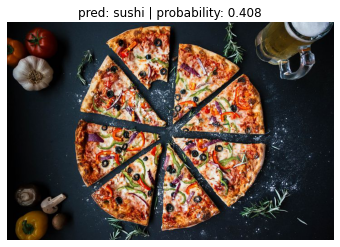

In [45]:
#predict on custom image
pred_and_plot_image(model = model,
                    image_path = custom_image_path,
                    class_names = class_names)

* Transfer learning often allows to you get good results with a relatively small amount of custom data.
* Knowing the power of transfer learning, it's a good idea to ask at the start of every problem, "does an existing well-performing model exist for my problem?"
* When using a pretrained model, it's important that your custom data be formatted/preprocessed in the same way that the original model was trained on, otherwise you may get degraded performance.
* The same goes for predicting on custom data, ensure your custom data is in the same format as the data your model was trained on.
There are several different places to find pretrained models from the PyTorch domain libraries, HuggingFace Hub and libraries such as timm (PyTorch Image Models).